In [1]:
import json
import numpy as np
import requests
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from datetime import timedelta
import pandas as pd
import flask_caching
from flask import Flask
import tqdm

In [2]:
# I have decided that I hate @lru_cache because it forces you to use it as an
# in-memory cache and you can't manually fuck with its contents.
# It seems a bit silly to initiate an unused flask app in a jupyter notebook,
# but flask_caching requires it.
app = Flask(__name__)
cache = flask_caching.Cache(app, config={'CACHE_TYPE': 'simple'})


# https://developer.spotify.com/documentation/general/guides/scopes/
scope = ','.join(filter(None, [
    "user-read-playback-state",
    "user-modify-playback-state",
    "user-library-read",
    "user-read-currently-playing",
    "user-follow-read",
    "playlist-read-private",
    "user-read-recently-played",
    "playlist-modify-private",
]))


@cache.memoize(timeout=60)
def get_sp():
    token = spotipy.util.prompt_for_user_token(
        "alsuren",
        scope=scope,
        client_id=None,
        client_secret=None,
        redirect_uri=None,
        cache_path=None,
        oauth_manager=None,
        show_dialog=False,
    )

    # TODO: spawn a thing in the background that can auto-refresh the token.
    # Python's threading is terrible though. I wonder if jupyter gives us
    # access to the underlying reactor?
    return spotipy.Spotify(auth=token)

In [3]:
def flatten_dictionaries(dictionary):
    """This will flatten api results for you.
    
    Pandas works best if you have a table-shaped thing.

    Note that it will leave a bunch of crufty keys if there are arrays
    of objects with lots of objects in them.
    
    You probably want to quickly inspect the structure of the resulting
    dataframe and select only the column names that you care about before
    you do any expensive sorting or reindexing operations.
    """
    result = {}
    for k1, node in dictionary.items():
        if k1 == 'available_markets':
            continue
        if isinstance(node, list):
            node = dict(enumerate(node))
        if isinstance(node, dict):
            for k2, leaf in flatten_dictionaries(node).items():
                result[f'{k1}.{k2}'] = leaf
        else:
            result[k1] = node
    return result

flatten_dictionaries({'some': {'deeply': {'nested': [{'dict': {'of': 'arrays'}}]}}})

{'some.deeply.nested.0.dict.of': 'arrays'}

In [4]:
# I don't like the argument order of the builtin map function
def list_map(iterable, function):
    return list(map(function, iterable))

# Fetch everyone's playlists from spotify

In [5]:
# https://developer.spotify.com/documentation/web-api/reference/playlists/get-list-users-playlists/

@cache.memoize(timeout=600)
def all_user_playlists(user):
    sp = get_sp()
    playlists = []
    while items := sp.user_playlists(user, offset=len(playlists))['items']:
        playlists += items
    return playlists

def all_user_playlists_df(user):
    return pd.DataFrame(
        list_map(all_user_playlists(user), flatten_dictionaries)
    )


In [6]:

@cache.memoize(timeout=60*60*24)
def all_playlist_tracks(playlist_uri):
    sp = get_sp()
    tracks = []
    
    while items := sp.playlist_tracks(playlist_uri, offset=len(tracks))['items']:
        tracks += items
    return tracks


def all_playlist_tracks_df(user):
    return pd.DataFrame(
        list_map(all_playlist_tracks(user), flatten_dictionaries)
    )


In [7]:

def crawl_playlists(user):
    seen = set()
    todo = [user]

    result = pd.DataFrame()
    while todo and len(seen) < 100:
        user = todo.pop(0)
        if user in seen:
            continue
        seen.add(user)

        df = all_user_playlists_df(user)
        try:
            todo.extend(df['owner.id'].value_counts().index)
        except KeyError:
            continue

        result = pd.concat([result, df])
    return result

# crawl_playlists('alsuren')

In [8]:
# playlists = crawl_playlists('alsuren')

In [9]:
# playlists.reset_index().to_feather('playlists.feather')

In [10]:
# Here's one I made earlier. Uncomment the above code if you don't
# have the playlists.feather file saved.
playlists = pd.read_feather('playlists.feather').drop_duplicates('uri')

In [11]:
playlists.columns

Index(['index', 'collaborative', 'description', 'external_urls.spotify',
       'href', 'id', 'images.0.height', 'images.0.url', 'images.0.width',
       'images.1.height', 'images.1.url', 'images.1.width', 'images.2.height',
       'images.2.url', 'images.2.width', 'name', 'owner.display_name',
       'owner.external_urls.spotify', 'owner.href', 'owner.id', 'owner.type',
       'owner.uri', 'primary_color', 'public', 'snapshot_id', 'tracks.href',
       'tracks.total', 'type', 'uri'],
      dtype='object')

# Explore surface-level playlist data

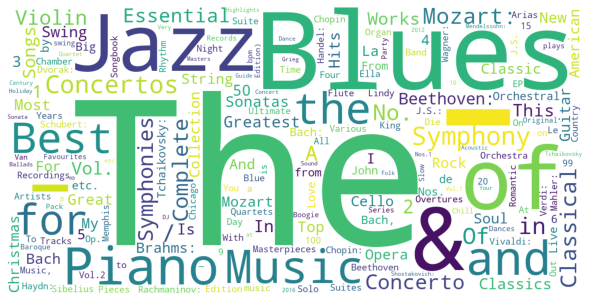

In [12]:
# Python program to generate WordCloud 

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from collections import Counter

fq = Counter(
    word
    for name in playlists['name']
    for word in name.split()
)

wordcloud = WordCloud(
    width=1200, height=600,
    background_color='white',
    stopwords=STOPWORDS,
    min_font_size=10,
).generate_from_frequencies(fq)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


In [13]:
lean_playlists = playlists[['uri', 'name', 'owner.id']].set_index('uri')

# Scrape playlist contents

In [14]:
playlist_contents = {}

In [15]:
def populate_playlist_contents():
    for playlist_uri in tqdm.cli.tqdm(loaded['uri']):
        if playlist_uri not in playlist_contents:
            tracks = all_playlist_tracks_df(playlist_uri)
            tracks['playlist_uri'] = playlist_uri
            playlist_contents[playlist_uri] = tracks
    return playlist_contents

# populate_playlist_contents()

In [16]:
# next(iter(playlist_contents.values()))['track.uri']

In [17]:
# all_tracks = pd.concat(playlist_contents.values())

In [18]:
# all_tracks.reset_index().to_feather('all_tracks.feather')

In [19]:
# TODO: work out how to make pandas store values as some dtype
# other than `object`, and see if that speeds up the load/save process

all_tracks = pd.read_feather('all_tracks.feather')

# Explore Playlist Counts per Track

In [20]:
playlists_by_track = all_tracks[
    ['playlist_uri', 'track.uri']
].set_index(['track.uri'])

In [21]:
playlists_by_track.loc['spotify:track:5U6kiSKFr2wIeaX8MuTAC8']

,playlist_uri
track.uri,
spotify:track:5U6kiSKFr2wIeaX8MuTAC8,spotify:playlist:7noRbq26JethJqAGneE1CS
spotify:track:5U6kiSKFr2wIeaX8MuTAC8,spotify:playlist:6GjOy5co9X6JqlPrK0YUHk


In [22]:
lean_playlists.loc[playlists_by_track.loc['spotify:track:0tkRgp8jYaPJy7YKxNIgVg']['playlist_uri']]

,name,owner.id
uri,,
spotify:playlist:0fcYVtGB0rdOUL5OfUUAcE,Slow Balboa,tenants
spotify:playlist:51qmf5Sigp9XzscO7CUs87,Starred #1,alsuren
spotify:playlist:51qmf5Sigp9XzscO7CUs87,Starred #1,alsuren
spotify:playlist:1OrEwPExGr4lepGowXQhWM,Research,katewiseman
spotify:playlist:0MvKALiTspAPUiLA30Zjeh,Slow balboa,katewiseman
spotify:playlist:6RwEWxsTQfhf0HoPWpQIgL,Swing Music for Dancers,jquinlanspotify
spotify:playlist:75AM3zYL3tY5Z2tpJvoBXm,Music for swing dancing,115155539
spotify:playlist:2UHmxpEcHI7yLe9LKIWvob,131 - 135 bpm (swing music - swingshoes.dk),swingshoesdk
spotify:playlist:2iQFSCvgVZCKLVZbTjF6do,Charleston Slow,tenants


In [23]:
def get_playlists_for_track(track_uri):
    try:
        return lean_playlists.loc[
            playlists_by_track.loc[track_uri]['playlist_uri']
        ]
    except KeyError:
        return None

get_playlists_for_track('spotify:track:5U6kiSKFr2wIeaX8MuTAC8')

,name,owner.id
uri,,
spotify:playlist:7noRbq26JethJqAGneE1CS,141 - 145 bpm (swing music - swingshoes.dk),swingshoesdk
spotify:playlist:6GjOy5co9X6JqlPrK0YUHk,You Should DJ Big Band (#1),wmgamble


In [24]:
def get_playlists_for_current_track():
    current = get_sp().current_playback()
    if current is None:
        print('no current track')
        return None
    return get_playlists_for_track(current['item']['uri'])
    
get_playlists_for_current_track()

,name,owner.id
uri,,
spotify:playlist:4r83vY3UOrvECpcFqQZfo0,41-45 Moderate/Fast Lindy (~160-180bpm),alsuren
spotify:playlist:4r83vY3UOrvECpcFqQZfo0,41-45 Moderate/Fast Lindy (~160-180bpm),alsuren
spotify:playlist:4r83vY3UOrvECpcFqQZfo0,41-45 Moderate/Fast Lindy (~160-180bpm),alsuren
spotify:playlist:57tXKCwKgRAYytczRDY9xY,bal @ 160-180 bpm (h-z not verified),alsuren
spotify:playlist:6SWyAMOjXh4396bSxNU3FS,Ah - Relaxed,alsuren
...,...,...
spotify:playlist:6MwiCU9LHVJRRgwKEJqUOm,El Arte del Swing Begginers,111818485
spotify:playlist:0V7k9eM7C6oT5A4cGEhBow,Carnaval SM 2017,111818485
spotify:playlist:76xyuzEdL3jCwwuNthuMui,8 counts Maru Xañez,111818485


In [25]:
get_playlists_for_track('spotify:track:5U6kiSKFr2wIeaX8MuTAC8')

,name,owner.id
uri,,
spotify:playlist:7noRbq26JethJqAGneE1CS,141 - 145 bpm (swing music - swingshoes.dk),swingshoesdk
spotify:playlist:6GjOy5co9X6JqlPrK0YUHk,You Should DJ Big Band (#1),wmgamble


In [26]:
# FIXME: trim this list of columns down
list(all_tracks.columns)

['index',
 'added_at',
 'added_by.external_urls.spotify',
 'added_by.href',
 'added_by.id',
 'added_by.type',
 'added_by.uri',
 'is_local',
 'primary_color',
 'track.album.album_type',
 'track.album.href',
 'track.album.id',
 'track.album.name',
 'track.album.release_date',
 'track.album.release_date_precision',
 'track.album.type',
 'track.album.uri',
 'track.artists.0.href',
 'track.artists.0.id',
 'track.artists.0.name',
 'track.artists.0.type',
 'track.artists.0.uri',
 'track.disc_number',
 'track.duration_ms',
 'track.explicit',
 'track.href',
 'track.id',
 'track.is_local',
 'track.name',
 'track.popularity',
 'track.preview_url',
 'track.track_number',
 'track.type',
 'track.uri',
 'video_thumbnail.url',
 'track.album.artists.0.external_urls.spotify',
 'track.album.artists.0.href',
 'track.album.artists.0.id',
 'track.album.artists.0.name',
 'track.album.artists.0.type',
 'track.album.artists.0.uri',
 'track.album.external_urls.spotify',
 'track.album.images.0.height',
 'track.a

In [27]:
# songs = all_tracks.drop('playlist_uri').drop_duplicates('track.uri').set_index('track.uri')

In [28]:
trimmed_all_tracks = all_tracks[['track.uri', 'track.name', 'track.artists.0.name']].drop_duplicates('track.uri').set_index('track.uri')


In [29]:
# playlists_by_track.to_feather('playlists_by_track.feather')

In [30]:
# pd.DataFrame(playlists_by_track).reset_index().to_feather('playlists_by_track.feather')

In [31]:
playlist_counts_by_track = playlists_by_track.groupby(lambda i: i).size().rename('playlist_count')

# Explore User Counts per Track

Basically the same as the above section.

In [32]:
users_by_playlist = playlists[['uri', 'owner.uri']]

users_by_track = playlists_by_track.reset_index().merge(
    users_by_playlist, left_on='playlist_uri', right_on='uri'
)[['track.uri', 'owner.uri']].drop_duplicates().set_index(['track.uri'])


users_by_track.loc['spotify:track:0tkRgp8jYaPJy7YKxNIgVg']


,owner.uri
track.uri,
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:tenants
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:alsuren
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:katewiseman
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:jquinlanspotify
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:115155539
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:swingshoesdk
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:1121277176
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:robertwiberg
spotify:track:0tkRgp8jYaPJy7YKxNIgVg,spotify:user:jonasgummesson


In [33]:
user_counts_by_track = users_by_track.groupby(lambda i: i).size().rename('user_count')

In [34]:
pd.DataFrame(
    user_counts_by_track
).join(trimmed_all_tracks).sort_values(
    by='user_count', ascending=False
)


,user_count,track.name,track.artists.0.name
spotify:track:5egcvD0mnAU1hLQulxxPKI,53,C Jam Blues (with Wynton Marsalis) - Live,Lincoln Center Jazz Orchestra
spotify:track:26zJinKqbORQyrDyMFLQhS,51,Blues My Naughty Sweetie Gives To Me,Sidney Bechet
spotify:track:2n845ZaLOgpNJ3RinFwE1W,41,My Baby Just Cares For Me,Nina Simone
spotify:track:23rgFPodbCa3l5XqCoUP2P,39,Lavender Coffin,Lionel Hampton
spotify:track:08A2Kb6BMw2lB1VwdcXaXx,38,Splanky - Remix; 1994 Remaster,Count Basie
...,...,...,...
spotify:track:2dRWHAT8P7F2jlgb1RnFYT,1,"Cello Suite No. 3 In C Major, Bwv 1009: III. C...",Victor Yoran
spotify:track:2dRWXOCg1OID8ZwNlCZUDW,1,"Violin Concerto No.2 in D, K.211: 1. Allegro m...",Wolfgang Amadeus Mozart
spotify:track:2dRWzfEofS6MRJI2ozCOe9,1,Cuba,Charlie Barnet
spotify:track:2dRZ3CTcwq4QK4tmoEQPEj,1,Make Believe Ballroom,Charlie Barnet and His Glen Island Casino Orch...


In [35]:
def get_users_for_track(track_uri):
    return users_by_track.loc[track_uri]

get_users_for_track('spotify:track:5U6kiSKFr2wIeaX8MuTAC8')

,owner.uri
track.uri,
spotify:track:5U6kiSKFr2wIeaX8MuTAC8,spotify:user:swingshoesdk
spotify:track:5U6kiSKFr2wIeaX8MuTAC8,spotify:user:wmgamble


In [36]:
def get_users_for_current_track():
    current = get_sp().current_playback()
    if current is None:
        print('no current track')
        return None
    return get_users_for_track(current['item']['uri'])
    
get_users_for_current_track()

,owner.uri
track.uri,
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:alsuren
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:tenants
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:kazaroth
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:ireon85
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:115155539
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:francesking
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:squishypeanut
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:muchopeor
spotify:track:0l1a5QgUWreryNaPk0h1VI,spotify:user:laura.h.knight
